In [1]:
import os
import zipfile
import shutil
import PIL
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision

from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torch.utils.data import random_split
from torchsummary import summary

In [2]:
# 5_1에서 사용한 dogs-vs-cats dataset 사용

train_dir = 'data/dogs-vs-cats/train'

train_set_dir = os.path.join(train_dir, 'train')
valid_set_dir = os.path.join(train_dir, 'valid')
test_set_dir = os.path.join(train_dir, 'test')

print(f'the number of train set : {len(os.listdir(train_set_dir))}')
print(f'the number of validation set : {len(os.listdir(valid_set_dir))}')
print(f'the number of test set : {len(os.listdir(test_set_dir))}')

the number of train set : 20000
the number of validation set : 2500
the number of test set : 2500


In [3]:
dog_files = [f'dog.{i}.jpg' for i in range(12500)]
cat_files = [f'cat.{i}.jpg' for i in range(12500)]

In [4]:
class CustomDataset(Dataset):
    '''
    __init__(self, files, root, mode='train', transform=None) :
        ㄴfiles : 이미지 파일 이름을 저장하고 있는 list
        ㄴroot : 이미지 파일이 존재하는 폴더 경로
        ㄴmode : 해당 dataset이 train용인지 eval용인지 체크
        ㄴtransform : 이미지의 전처리를 위한 torchvision.transform
    '''
    def __init__(self, files, root, mode='train', transform=None):
        self.files = files
        self.root = root
        self.mode = mode
        self.transform = transform
        
        if 'cat' in files[0]:
            self.label = 0
        else:
            self.label = 1
            
                
    '''
    __len__(self) : Dataset의 길이를 반환하기 위한 메소드
    '''    
    def __len__(self):
        return len(self.files)
    
    
    '''
    __getitem__(self, index) : 주어진 key에 해당하는 data를 반환하는 메소드이며,
                               key에 해당하는 이미지 파일을 읽고, 전처리 과정을 통해서 data를 리턴합니다. 
                               mode='train'일 경우에는 label을 반환하고, 'train'용이 아닌 경우에는 label을 모르기 때문에 
                               실제 이미지 파일의 경로를 반환하도록 합니다.
    '''  
    def __getitem__(self, index):
        img = PIL.Image.open(os.path.join(self.root, self.files[index]))
        
        if self.transform:
            img = self.transform(img)
        if self.mode == 'train':
            return img, np.array([self.label])
        else:
            return img, self.files[index]

In [5]:
train_transform = transforms.Compose([transforms.Resize((256, 256)),
                                      transforms.RandomCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor()
                                     ])

test_transform = transforms.Compose([transforms.Resize((224, 224)),
                                     transforms.ToTensor()
                                    ])

In [6]:
train_dog_dataset = CustomDataset(dog_files[:10000], train_set_dir, transform=train_transform)
train_cat_dataset = CustomDataset(cat_files[:10000], train_set_dir, transform=train_transform)
valid_dog_dataset = CustomDataset(dog_files[10000:11250], valid_set_dir, transform=test_transform)
valid_cat_dataset = CustomDataset(cat_files[10000:11250], valid_set_dir, transform=test_transform)
test_dog_dataset = CustomDataset(dog_files[11250:12500], test_set_dir, transform=test_transform)
test_cat_dataset = CustomDataset(cat_files[11250:12500], test_set_dir, transform=test_transform)
 
train_dataset = torch.utils.data.ConcatDataset([train_dog_dataset, train_cat_dataset])
valid_dataset = torch.utils.data.ConcatDataset([valid_dog_dataset, valid_cat_dataset])
test_dataset = torch.utils.data.ConcatDataset([test_dog_dataset, test_cat_dataset])

In [7]:
train_dataset[0]

(tensor([[[0.5059, 0.5176, 0.5255,  ..., 0.6196, 0.6078, 0.5922],
          [0.5020, 0.5176, 0.5216,  ..., 0.6157, 0.6039, 0.5882],
          [0.5059, 0.5176, 0.5176,  ..., 0.6157, 0.6078, 0.6000],
          ...,
          [0.3686, 0.3333, 0.3647,  ..., 0.2627, 0.2784, 0.2784],
          [0.3765, 0.4196, 0.4039,  ..., 0.2627, 0.2745, 0.2824],
          [0.4431, 0.4627, 0.4627,  ..., 0.2706, 0.2667, 0.2784]],
 
         [[0.4902, 0.5020, 0.5098,  ..., 0.6275, 0.6157, 0.6000],
          [0.4863, 0.5020, 0.5059,  ..., 0.6235, 0.6118, 0.5961],
          [0.4902, 0.5020, 0.5020,  ..., 0.6235, 0.6157, 0.6078],
          ...,
          [0.3490, 0.3137, 0.3451,  ..., 0.2980, 0.3176, 0.3176],
          [0.3569, 0.3961, 0.3804,  ..., 0.3020, 0.3137, 0.3216],
          [0.4118, 0.4314, 0.4275,  ..., 0.3098, 0.3059, 0.3176]],
 
         [[0.5451, 0.5569, 0.5647,  ..., 0.6745, 0.6627, 0.6471],
          [0.5412, 0.5569, 0.5608,  ..., 0.6706, 0.6588, 0.6431],
          [0.5451, 0.5569, 0.5569,  ...,

In [9]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128)

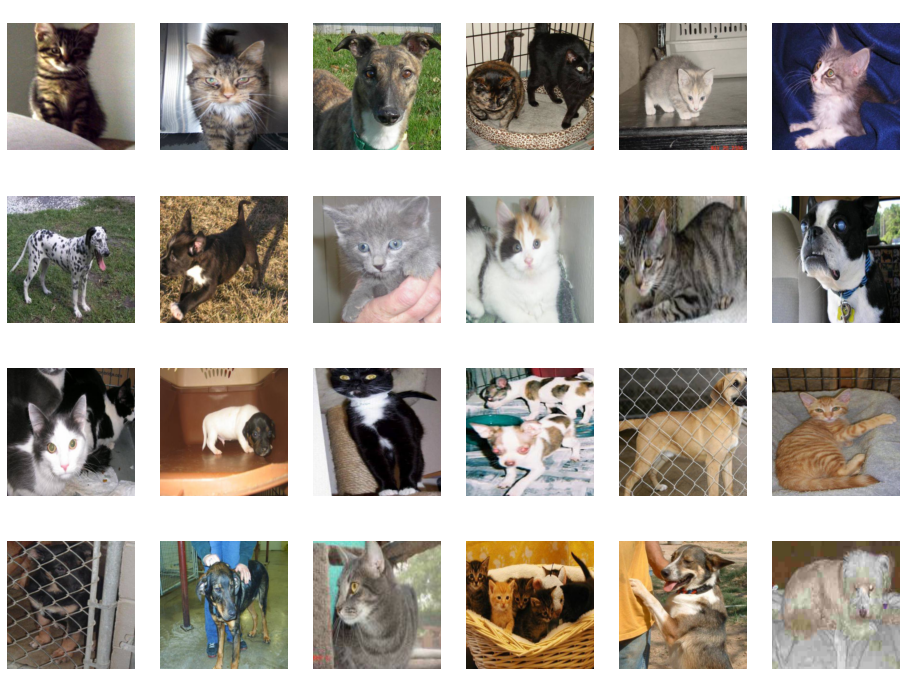

In [10]:
samples, labels = iter(train_loader).next()
classes = {0:'cat', 1:'dog'}
fig = plt.figure(figsize=(16,24))

for i in range(24):
    a = fig.add_subplot(4,6,i+1)
    a.set_title(classes[labels[i].item()], color='w')
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))
    
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

----------------------------------------------------------------------------------------------------------------------------------------

## Pretrained model: ResNet50

![resnet50](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FdWvmSt%2Fbtq8HUxeGbt%2FRYjh295Vsf1UTixT1xsKNk%2Fimg.png)

![resnet50_2](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FFRx1v%2Fbtq8F7xPXK9%2FYpitlKwjpdAuwR1MyEJyi1%2Fimg.png)

In [56]:
model_res50 = torchvision.models.resnet50(pretrained=True)
model_res50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

해당 네트워크는 ImageNet dataset으로 학습되어 있습니다.
ImageNet dataset은 1000개의 label로 구성되어 있기 때문에, fc layer의 out_features가 1000으로 되어 있습니다.
우리는 개와 고양이 분류를 위해 binary classification을 진행해야 합니다. 따라서 이 부분의 수정이 필요합니다.

In [57]:
input_features_fc_layer = model_res50.fc.in_features
input_features_fc_layer

2048

개와 고양이 분류를 위한 nn.Sequential을 구성합니다. 
마지막 출력이 1이 되도록(Sigmoid 연산까지 추가해줍니다) 구성하고, fc에 할당해줍니다.

In [58]:
model_res50.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(input_features_fc_layer, 1024),
    nn.Dropout(0.2),
    nn.Linear(1024, 512),
    nn.Dropout(0.1),
    nn.Linear(512, 1),
    nn.Sigmoid()
)

In [60]:
model_res50.cuda()
summary(model_res50, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

fit 함수는 model, loss function, optimizer와 epoch, train_loader, valid_loader를 인자로 받고 있습니다.

설정한 epoch만큼 학습을 진행하고, 매 epoch가 끝나면 validation check를 진행하도록 했습니다. 

설정한 epoch만큼 학습이 끝난 후에는 loss와 accuracy의 변화 추이를 살펴보기 위해서 매 epoch마다 loss, acc를 저장하고 있으며, acc는 한 epoch에서 label과 일치하는 갯수를 저장해서 총 data 갯수로 나누어서 계산하게 됩니다.

모델의 output은 sigmoid를 거쳐서, label class가 1인 확률이 됩니다.(input image가 dog일 확률) 따라서, 0.5이상은 1, 0.5미만은 0으로 처리해주고, 실제 label과 비교해서 일치하는지 확인합니다.

In [63]:
def fit(model, criterion, optimizer, epochs, train_loader, valid_loader):
    model.train()
    
    train_loss = 0
    train_acc = 0
    train_correct = 0
    
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []
    
    for epoch in range(epochs):
        start = time.time()
        for train_x, train_y in train_loader:
            model.train()
            train_x, train_y = train_x.to(device), train_y.to(device).float()
            optimizer.zero_grad()
            pred = model(train_x)
            loss = criterion(pred, train_y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            y_pred = pred.cpu()
            y_pred[y_pred >= 0.5] = 1
            y_pred[y_pred < 0.5] = 0
            train_correct += y_pred.eq(train_y.cpu()).int().sum()
        
        # validation data check
        valid_loss = 0
        valid_acc = 0
        valid_correct = 0
        for valid_x, valid_y in valid_loader:
            with torch.no_grad():
                model.eval()
                valid_x, valid_y = valid_x.to(device), valid_y.to(device).float()
                pred = model(valid_x)
                loss = criterion(pred, valid_y)
            valid_loss += loss.item()
            
            y_pred = pred.cpu()
            y_pred[y_pred >= 0.5] = 1
            y_pred[y_pred < 0.5] = 0
            valid_correct += y_pred.eq(valid_y.cpu()).int().sum()
        
        train_acc = train_correct/len(train_loader.dataset)
        valid_acc = valid_correct/len(valid_loader.dataset)
        
        print(f'{time.time() - start:.3f}sec : [Epoch {epoch+1}/{epochs}] -> train loss: {train_loss/len(train_loader):.4f}, train acc: {train_acc*100:.3f}% / valid loss: {valid_loss/len(valid_loader):.4f}, valid acc: {valid_acc*100:.3f}%')
        
        train_losses.append(train_loss/len(train_loader))
        train_accuracies.append(train_acc)
        valid_losses.append(valid_loss/len(valid_loader))
        valid_accuracies.append(valid_acc)
        
        train_loss = 0
        train_acc = 0
        train_correct = 0
    
    plt.plot(train_losses, label='train loss')
    plt.plot(valid_losses, label='valid loss')
    plt.legend()
    plt.title('loss')
    plt.show()
    
    plt.plot(train_accuracies, label='train accuracy')
    plt.plot(valid_accuracies, label='valid accuracy')
    plt.legend()
    plt.title('accuracy')
    plt.show()

이제 loss function과 optimizer를 생성하고 학습을 진행해보도록 하겠습니다.

Loss function으로는 Binary Cross Entropy Loss(BCELoss())를 사용했고, Optimizer는 Adam을 사용했으며, ResNet을 fine turning하기 때문에 learning rate를 0.00001로 낮게 설정했습니다.

114.864sec : [Epoch 1/10] -> train loss: 0.0797, train acc: 98.710% / valid loss: 0.0338, valid acc: 98.640%
114.185sec : [Epoch 2/10] -> train loss: 0.0172, train acc: 99.405% / valid loss: 0.0254, valid acc: 99.200%
114.797sec : [Epoch 3/10] -> train loss: 0.0094, train acc: 99.685% / valid loss: 0.0316, valid acc: 99.040%
116.299sec : [Epoch 4/10] -> train loss: 0.0068, train acc: 99.750% / valid loss: 0.0303, valid acc: 98.920%
114.728sec : [Epoch 5/10] -> train loss: 0.0052, train acc: 99.850% / valid loss: 0.0308, valid acc: 99.120%
111.754sec : [Epoch 6/10] -> train loss: 0.0031, train acc: 99.920% / valid loss: 0.0299, valid acc: 99.160%
113.040sec : [Epoch 7/10] -> train loss: 0.0025, train acc: 99.930% / valid loss: 0.0331, valid acc: 99.080%
112.231sec : [Epoch 8/10] -> train loss: 0.0021, train acc: 99.950% / valid loss: 0.0335, valid acc: 99.000%
112.978sec : [Epoch 9/10] -> train loss: 0.0019, train acc: 99.935% / valid loss: 0.0382, valid acc: 99.040%
115.383sec : [Epoch

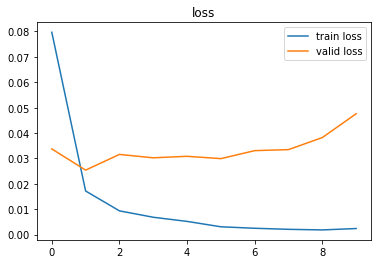

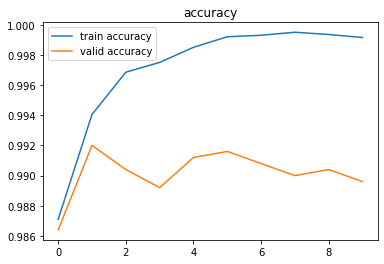

In [64]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_res50.parameters(), lr=1e-5)
 
fit(model_res50, criterion, optimizer, 10, train_loader, valid_loader)

In [65]:
def eval(model, criterion, test_loader):
    with torch.no_grad():
        model.eval()
        correct = 0
        losses = 0
        for test_x, test_y in test_loader:
            test_x, test_y = test_x.to(device), test_y.to(device).float()
            pred = model(test_x)
            loss = criterion(pred, test_y)
            
            y_pred = pred.cpu()
            y_pred[y_pred >= 0.5] = 1
            y_pred[y_pred < 0.5] = 0
            
            losses += loss.item()
            correct += y_pred.eq(test_y.cpu()).int().sum()
    print(f'eval loss: {losses/len(test_loader):.4f}, eval acc: {correct/len(test_loader.dataset)*100:.3f}%')

In [66]:
eval(model_res50, criterion, test_loader)

eval loss: 0.0364, eval acc: 99.000%


In [71]:
test_dir = 'data/dogs-vs-cats/test'
submit_files = [f'{i}.jpg' for i in range(1, 12500+1)]
submit_dataset = CustomDataset(submit_files, test_dir, mode='test', transform=test_transform)
submit_loader = torch.utils.data.DataLoader(submit_dataset, batch_size=128, shuffle=False)

In [72]:
def predict(model, data_loader):
    with torch.no_grad():
        model.eval()
        ret = None
        for img, files in data_loader:
            img = img.to(device)
            pred = model(img)
            
            if ret is None:
                ret = pred.cpu().numpy()
            else:
                ret = np.vstack([ret, pred.cpu().numpy()])
    return ret
   
pred = predict(model_res50, submit_loader)

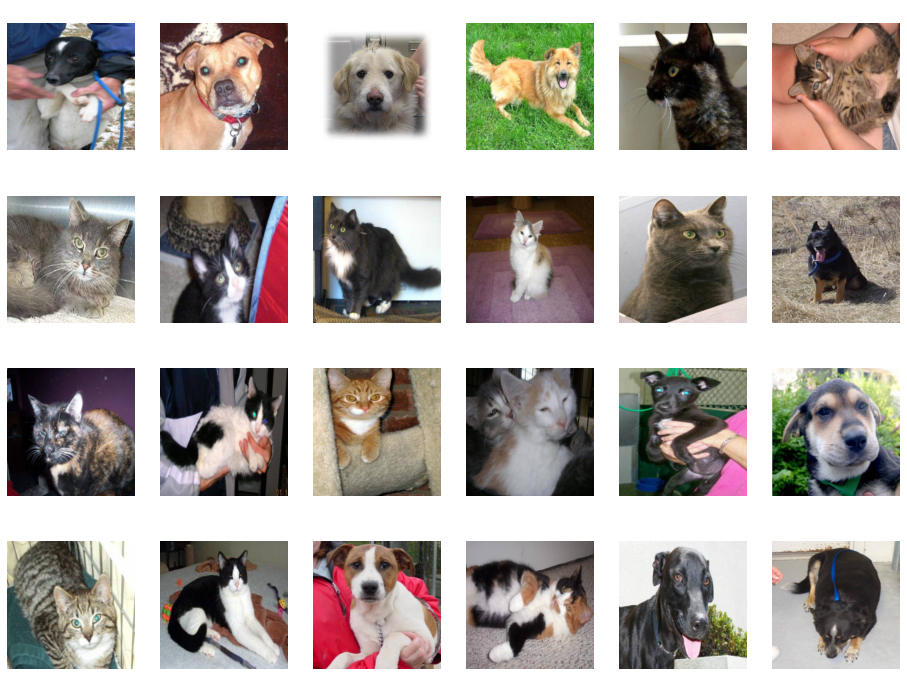

In [74]:
sample_pred = pred[:24]
sample_pred[sample_pred >= 0.5] = 1
sample_pred[sample_pred < 0.5] = 0
 
imgs, files = iter(submit_loader).next()
classes = {0:'cat', 1:'dog'}
fig = plt.figure(figsize=(16,24))
for i in range(24):
    a = fig.add_subplot(4,6,i+1)
    a.set_title(classes[sample_pred[i][0]], color='w')
    a.axis('off')
    a.imshow(np.transpose(imgs[i].numpy(), (1,2,0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)